In [1]:
!pip install hdbscan
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.8 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-linux_x86_64.whl size=3585030 sha256=45624d20a700c70a246749f8bc04978c184becf6e2f6227e5b5912dc97074b81
  Stored in directory: /root/.cache/pip/wheels/28/5e/ed/5989da4cc423a222a47cbb4fde5d6c0eff4590d922e45f233c
Successfully built hdbscan
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 86.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 91.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.1/802.1 kB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB

In [2]:
import hdbscan
import pandas as pd
import numpy as np
#%matplotlib ipympl
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
sys.path.append('../autoencoder')
# sys.path.append('/notebooks/Beta-VAE/')
from models import*

from src.band_plotters import*
from src.Tiff32Image import*
from src.TensorImageNoised import *

sys.path.append('/notebooks/band-fingerprint/autoencoder/resnet_autoencoder')
sys.path.append('/notebooks/band-fingerprint/src')

from model import *

from ae_misc import *

In [29]:
FINGERPRINT_LENGTH = 96

#FINGERPRINT_NAME = "functional_10dpi_bernoulli_VAE_L={0}".format(FINGERPRINT_LENGTH)
FINGERPRINT_NAME = "128x128_resnet_L={0}".format(FINGERPRINT_LENGTH)
#FINGERPRINT_NAME = "all_k_branches_histogram_-8_to_8".format(FINGERPRINT_LENGTH)
#FINGERPRINT_NAME = "128x128_random_erase_resnet18_VAE_L={0}".format(FINGERPRINT_LENGTH)

PERPLEXITY = 30
FLAT_ONLY = True
BORING_COLUMNS = ["flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"

## Load Data

In [31]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,88,89,90,91,92,93,94,95,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,...,-0.569167,4.218755,3.929942,3.208841,-0.750617,3.923216,2.511832,2.885870,26.073044,-130.347210
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,...,-1.346009,5.466850,2.573174,2.256038,-1.000885,4.135562,3.334785,2.493360,120.749210,-97.311080
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,...,-0.648186,5.231957,2.888509,2.278241,-0.929371,4.215997,3.918979,2.272637,-89.200950,-6.013504
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,...,-1.250727,4.316664,3.028040,3.152872,-1.040935,3.332638,3.249476,3.926476,4.976043,19.414225
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,...,-0.825645,4.682211,3.132785,2.019661,-0.527658,4.162311,2.707824,2.291461,1.433650,-44.735523


## Cluster

In [32]:
fingerprint_cols = [str(i) for i in range(FINGERPRINT_LENGTH)]
BORING_COLUMNS += fingerprint_cols

In [48]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=3, min_samples=3, p=0.2)
#clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
clusterer.fit(df[fingerprint_cols])


df["labels"] = clusterer.labels_


# View cluster for bernoulli auto-encoded fingerprint


In [7]:
# old static model
# # change path to the location of the desired trained model
# model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# # name of the energy{name} folder which holds the input band tensors
# CNN_input_file_index = "_12_nearest_bands"
# # load the model that we have already trained on the data
# trained_model = load_learner(model_path)


bernoulli_input_file_index="no_dos_bw_2/dpi_10"
    
bernoulli_model = BetaVAE_B(z_dim=64, nc=3)

checkpoint = torch.load("/notebooks/Beta-VAE/checkpoints/BW_B_gamma100_z64/last")
bernoulli_model.load_state_dict(checkpoint['model_states']['net'])

bernoulli_model.eval()


def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])
    print(num_plots)
    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        #ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        
        ax[i].set_xlabel(index)
        
    for i, index in enumerate(df[df.labels==label].index):
        #plot(index)
        # old static model
        #view_prediction(index, trained_model.model, -17, 20, width=128)
        # VAE model
        view_prediction_images(index, bernoulli_model, image_directory="../../../storage/2dmatpedia/images/{0}".format(bernoulli_input_file_index), width=64, height=64, height_mode="pad", act_func=F.sigmoid)

#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

NameError: name 'BetaVAE_B' is not defined

In [19]:
# old static model
# # change path to the location of the desired trained model
# model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# # name of the energy{name} folder which holds the input band tensors
# CNN_input_file_index = "_12_nearest_bands"
# # load the model that we have already trained on the data
# trained_model = load_learner(model_path)


VAE_input_file_index="energies4"
    
VAE_model = BetaVAE_B(z_dim=32)

checkpoint = torch.load("/notebooks/Beta-VAE/checkpoints/energies4_B_beta10_z32/last")
VAE_model.load_state_dict(checkpoint['model_states']['net'])

VAE_model.eval()


def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        #ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        
        ax[i].set_xlabel(index)
        
    for i, index in enumerate(df[df.labels==label].index):
        #plot(index)
        # old static model
        #view_prediction(index, trained_model.model, -17, 20, width=128)
        # VAE model
        view_prediction(index, VAE_model, -7, 7, image_directory="energies4", width=64, height=64, height_mode="pad", act_func=F.sigmoid)


#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=(111))

/notebooks/Beta-VAE/model.py:191: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


interactive(children=(IntSlider(value=111, description='label', max=333, min=-111), Output()), _dom_classes=('…

<function __main__.view_cluster(label)>

# View cluster for any fingerprint

In [34]:
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        # ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        plt.xlabel(index)
        plt.title("fingerprint")
        plt.show()
        #plot(index)

interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

interactive(children=(IntSlider(value=42, description='label', max=86, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

# VIEW cluster for resnet AE or VAE (must change model import below, and the .predict function in view_cluster!)

In [7]:
class Binarize(Transform):
    def __init__(self, threshold=0.8):self.threshold=threshold
    def encodes(self, o): 
        # print(o)
        mask = (o > (255 * self.threshold))
        return mask * 255

In [8]:
def bce_loss(pred, targ):
    x_recon, mu, logvar = pred
    
    return nn.BCEWithLogitsLoss()(x_recon, targ) + 0.05 * kld_mean_loss(mu, logvar)

In [104]:
# MUST CHANGE FOR DIFFERENT LATENT LENGTH MODEL!
learn = load_learner("../autoencoder/trained_models/resnet18_size128_lossMSE_channels16.pkl")

#model_path = "../autoencoder/trained_models/vae_resnet18_size128_lossbcekl_randerase_channels4.pkl"
#learn = load_learner(model_path)

def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        plt.xlabel(index)
        plt.title("fingerprint")
        plt.show()
        plot(index)
        plt.show()
        
        # FOR NORMAL AE
        out = learn.predict(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        show_image(out[1])
        
        # FOR VAE
        #x_recon, mu, sigma = predict(learn,DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        #show_image(torch.sigmoid(x_recon[0]))
        #x_recon.size()
        
        plt.show()
        
#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=1)

interactive(children=(IntSlider(value=1, description='label', max=3, min=-1), Output()), _dom_classes=('widget…

<function __main__.view_cluster(label)>

In [38]:
df[df.formula=="AsCuLi2"]

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,57,58,59,60,61,62,63,fx,fy,labels
ID,,,,,,,,,,,,,,,,,,,,,


## Rerun TSNE (ONLY IF ON FLAT SUBSET)

In [43]:
if FLAT_ONLY:
    tsne = manifold.TSNE(n_components=2, early_exaggeration=200.0, init="pca",learning_rate=100, random_state=0, perplexity=5,n_iter=10000, verbose=2)
    fingerprint_2d = tsne.fit_transform(df[fingerprint_cols])
    df.fx, df.fy = fingerprint_2d[:, 0], fingerprint_2d[:, 1]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 1.499052
[t-SNE] Computed conditional probabilities in 0.008s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 2440.4047852, gradient norm = 2.6684825 (50 iterations in 1.009s)
[t-SNE] Iteration 100: error = 2476.0375977, gradient norm = 2.6861820 (50 iterations in 0.257s)
[t-SNE] Iteration 150: error = 2488.1672363, gradient norm = 2.4997022 (50 iterations in 0.221s)
[t-SNE] Iteration 200: error = 2484.5449219, gradient norm = 2.6145856 (50 iterations in 0.284s)
[t-SNE] Iteration 250: error = 2480.2543945, gradient norm = 2.6028996 (50 iterations in 0.296s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 2480.254395
[t-SNE] Iteration 300: error = 5.0071793, gradient norm = 0.0085753 (50 iterations in 0.295s)
[t-SNE] Iteration 350: error = 4.1755595, gradient norm = 0.0038060 (50 iterations in 0.312s)
[t-SNE] Iteration 400: error = 3.7235725, gradient norm = 0.0029472 (50 iterations in 0.210s)
[t-SNE] Iteration 450: error = 3.4817085, gradient norm = 0.0013971 (50 iterations in 0.180s)
[t-SNE] Iteration 500: error = 3.3147509, gradient norm = 0.

## Plots

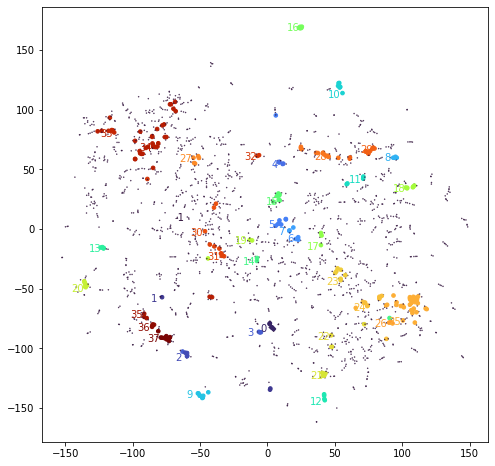

In [50]:
labels = clusterer.labels_

fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*13
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprint_2d[rep_id,:]+[-6,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=10).draggable()

plt.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")
plt.show()

Output()

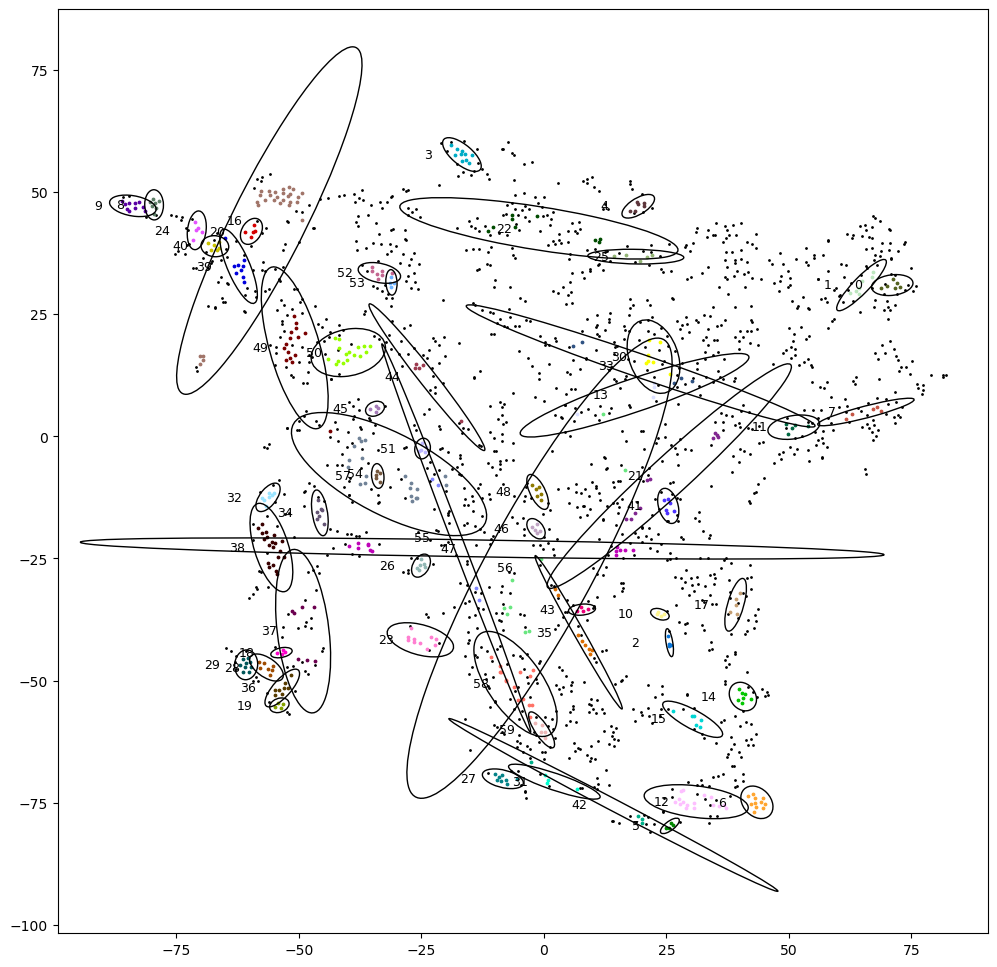

In [17]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df,"labels", ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Output()

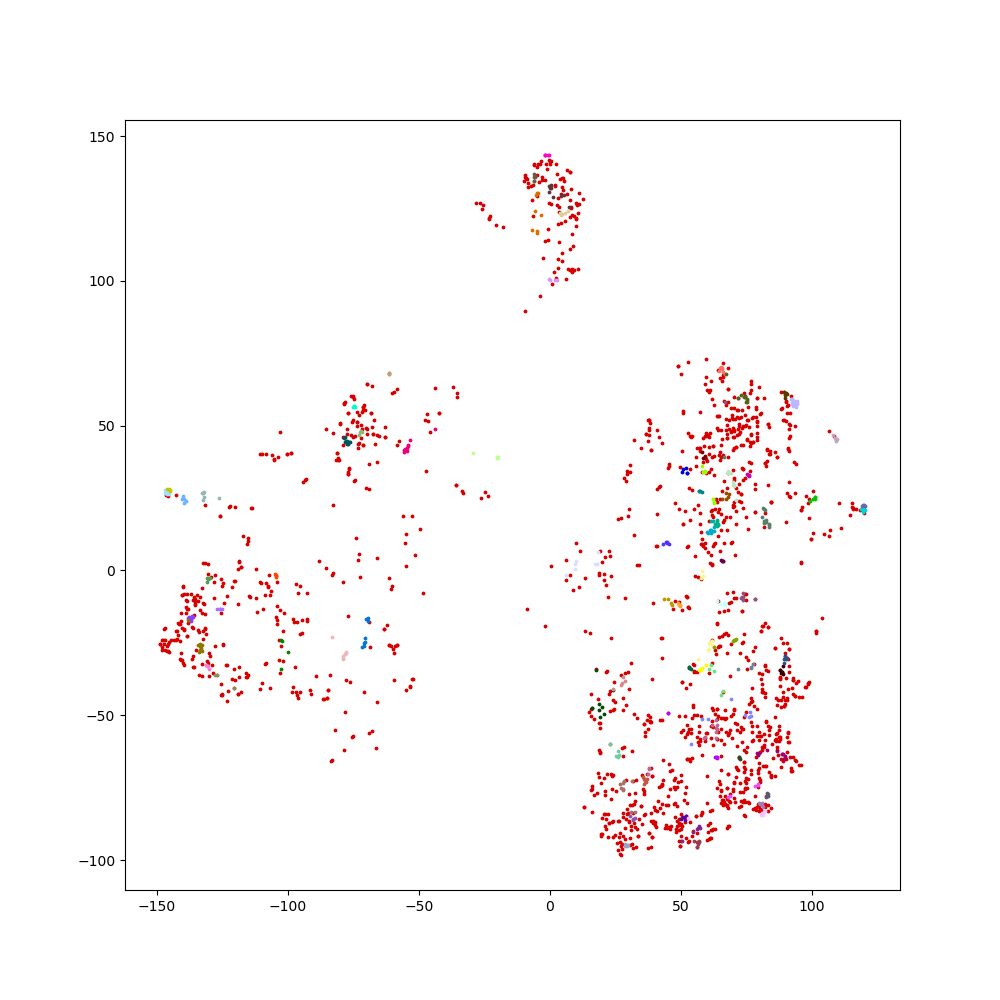

In [12]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(10, 10))
ax = plot_groups(df,"labels", ax=ax)
#ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# 2D HISTOGRAM FOR HDBSCAN PARAMETER OPTIMISATION

In [41]:
MS_vals = np.arange(2,12,1)
MCS_vals = np.arange(2,12,1)

DBCV_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_cluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_uncluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))

for i,MS in enumerate(MS_vals):
    for j,MCS in enumerate(MCS_vals):
        #print(MS,MCS)
        #print(i,j)
        clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                                gen_min_span_tree=True, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=MCS, min_samples=MS, p=0.2)
        #clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
        clusterer.fit(df[fingerprint_cols])

        df["labels"] = clusterer.labels_
        
        DBCV_vals[-(j+1),i] = clusterer.relative_validity_ 
        N_cluster_vals[-(j+1),i] = len(np.unique(clusterer.labels_))-1
        N_uncluster_vals[-(j+1),i] = len(df[df["labels"]==-1])

        

Text(0.5, 1.0, '[[0.07408321 0.05719583 0.02683594 0.02088851 0.0214418  0.01430383\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.0721241  0.05719583 0.03163518 0.02551871 0.0214418  0.02067047\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.07654506 0.06111259 0.03566593 0.02551871 0.0312092  0.02067047\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.07786822 0.06488722 0.03944247 0.03656153 0.03492427 0.02422886\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.09179331 0.07460552 0.04893343 0.03985142 0.03820086 0.03080423\n  0.01911904 0.01781102 0.01064017 0.00635515]\n [0.0778927  0.09393872 0.0545307  0.03516922 0.04101874 0.0363882\n  0.03163183 0.0206466  0.01636958 0.01439212]\n [0.08311159 0.06688069 0.05916007 0.04210127 0.04101874 0.0363882\n  0.03395227 0.02295781 0.02162625 0.01697509]\n [0.07766967 0.07191693 0.05731166 0.04578998 0.04101874 0.0363882\n  0.03395227 0.0266888  0.02162625 0.0206336 ]\n [0.13138373 0.075194   0.06322128 0.0468562  0.046

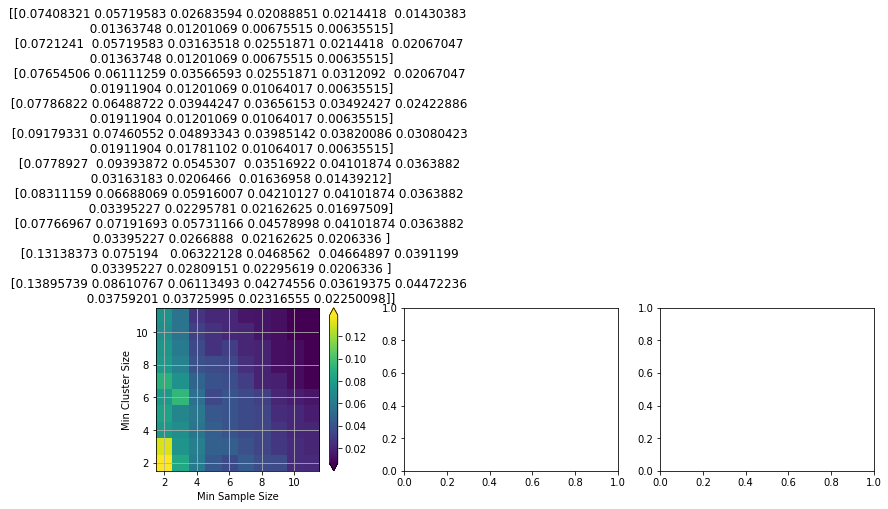

In [55]:
parameter_mesh = np.meshgrid(MS_vals, MCS_vals)
#plt.contourf(MS_vals,MCS_vals,DBCV_vals,5)
#plt.show()
#plt.imshow(DBCV_vals, extent=[2,12,2,12])
names = [DBCV_vals, N_cluster_vals, N_uncluster_vals]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

D = ax1.imshow(name, extent=[1.5,11.5,1.5,11.5])
fig.colorbar(D, ax=ax1, extend='both')

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")

ax1.grid()
ax1.set_title("{0}".format(name))
#plt.show()

#plt.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(DBCV_vals, interpolation='bilinear')

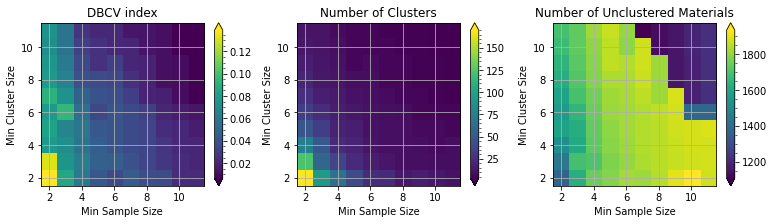

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)


# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow
pos = ax1.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar3 = fig.colorbar(pos, ax=ax1, extend='both')

# repeat everything above for the negative data
# you can specify location, anchor and shrink the colorbar
neg = ax2.imshow(N_cluster_vals, extent=[1.5,11.5,1.5,11.5])
cbar2 = fig.colorbar(neg, ax=ax2, extend='both')



# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = ax3.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar1 = fig.colorbar(pos_neg_clipped, ax=ax3, extend='both')
cbar1.minorticks_on()
cbar2.minorticks_on()
cbar3.minorticks_on()

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")
ax1.grid()
ax1.set_title("DBCV index")

ax2.set_xlabel("Min Sample Size")
ax2.set_ylabel("Min Cluster Size")
ax2.grid()
ax2.set_title("Number of Clusters")

ax3.set_xlabel("Min Sample Size")
ax3.set_ylabel("Min Cluster Size")
ax3.grid()
ax3.set_title("Number of Unclustered Materials")

plt.savefig("2d_hist_hdbscan_params", dpi=100, bbox_inches="tight")
plt.show()
